<a href="https://colab.research.google.com/github/Leos1999/MarketTrendAnalyser/blob/master/Stock_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Intraday Strategy Using LSTM

  > This notebook is created to implement an intraday strategy and a LSTM neural network aids this strategy.


> The dataset used is https://drive.google.com/drive/folders/1pU6qCnlxy6BlJW95tOcAV9_hOzyq7nKm. 
  It's the data from New York Stock Exchange(NYSE).

## The strategy 



> We are given daily data of a stock.



*   Open Price
*   Close Price
*   High
*   Low
*   Volume

> The strategy is that if we can predict the position of next day's open and close compared to the previous day's open and close. Then we can effectively take a buy or sell for the whole day.Now I have concentrated on a whole day concept but we could apply it to 1 hour period or even 1 minute period if we have the corresponding data.

> For example, consider AAPL today's open and close ie, 353.25 and 361.78 respectively.
<br>
  <p>Suppose, tomorrow's values are 365 and 378 for open and close respectively.From this we can incur that there is an uptrend in the graph.If, we had known this trend earlier,we could easily go for a long position. And if it's a down trend then for a short position.</p>
  <p>If we could train a neural network to replicate the trend then we could easily take a position at the beginning of the day and except the final result to be a profit. I have attached a LSTM which can accurately predict the future trend for the next 10 days.</p>
  <p>The LSTM can predict the trend of both **open price** as well as the **close price**. Thereby,giving an idea of tomorrow's trend.</p> 
  <p>For improving this strategy, we could build two more LSTM which could predict the **high** and **low** prices of the same day so that we could set:</p>
*   a trigger,
*   a stoploss,
*   & a target

<P> I have tried to build the LSTMs with an accuracy of upto 85% but needs improvements.</p>

<p> If it can be improved then, we could set the values as follows:

   * if up-trend(predicted) then,
  
         Trigger = above and close to 'low' price
         Stoploss = below and close to 'low' price
         Target = below and close to 'high' price
         SquareOff will be close to 'close' price

   * if down-trend(predicted) then,
  
         Trigger = below and close to 'high' price
         Stoploss = above and close to 'high' price
         Target = below and close to 'low' price
         SquareOff will be close to 'close' price




  









In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "leosabraham" # username from the Kaggle API json file
os.environ['KAGGLE_KEY'] = "9e8785651868d3ca4384269a20773ea2" # key from the json file
!kaggle datasets download -d dgawlik/nyse
!unzip /content/nyse.zip

 46% 14.0M/30.7M [00:00<00:00, 21.6MB/s]
100% 30.7M/30.7M [00:00<00:00, 62.2MB/s]
Archive:  /content/nyse.zip
  inflating: fundamentals.csv        
  inflating: prices-split-adjusted.csv  
  inflating: prices.csv              
  inflating: securities.csv          


In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [ ]:
prices = pd.read_csv("/content/prices-split-adjusted.csv")
prices.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [ ]:
company = 'ABT'
data = prices.loc[prices['symbol']==company]
data = data.drop('date',axis=1)
data = data.drop('symbol',axis=1)
X_normalizer = MinMaxScaler(feature_range = (0,1))
y_normalizer = MinMaxScaler(feature_range = (0,1))
data.head()

,open,close,low,high,volume
256,26.000339,26.129884,25.870792,26.177866,10829000.0
723,26.134683,25.918773,25.789226,26.134683,10562100.0
1191,25.880388,26.062713,25.837208,26.096298,11401400.0
1659,26.057914,26.278623,25.942762,26.283420,12857200.0
2127,26.273824,26.412967,26.235441,26.508926,12148600.0


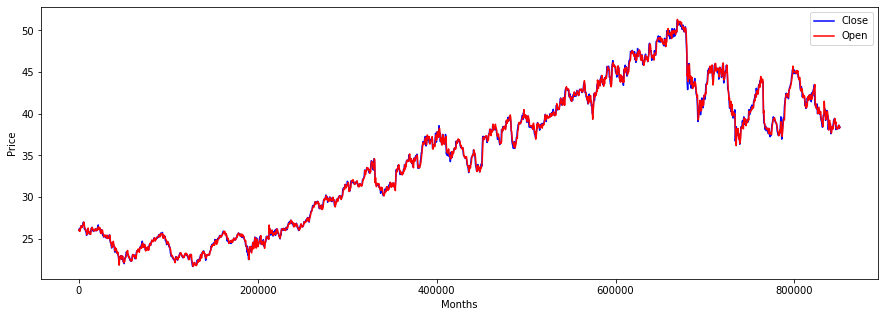

In [ ]:
plt.figure(figsize = (15, 5))
plt.plot(data['close'],color='blue',label = "Close")
plt.plot(data['open'],color='red',label = "Open")
plt.xlabel("Months")
plt.ylabel("Price")
plt.legend()
plt.show()

In [ ]:
def preprocessor(X,y,window=4,test=False):
  if test:
    X_norm = X_normalizer.transform(X)
    y = y.reshape(-1,1)
    y_norm = y_normalizer.transform(y)
  else:
    X_norm = X_normalizer.fit_transform(X)
    y = y.reshape(-1,1)
    y_norm = y_normalizer.fit_transform(y)
  pre_X = []
  pre_y = []
  for i in range(window,len(y)):
    pre_X.append(X_norm[i-window:i,:])
    pre_y.append(y_norm[i,0])
  pre_X = np.array(pre_X)
  pre_y = np.array(pre_y)
  return pre_X,pre_y

def data_shuffler(pre_X,pre_y,split_size=0.85):
  concat = np.c_[pre_X.reshape(len(pre_X), -1), pre_y.reshape(len(pre_y), -1)]
  np.random.shuffle(concat)
  shuf_X = concat[:, :pre_X.size//len(pre_X)].reshape(pre_X.shape)
  shuf_y = concat[:, pre_X.size//len(pre_X):].reshape(pre_y.shape)
  train_size = int(split_size * len(pre_X))
  train_X = shuf_X[0:train_size]
  train_y = shuf_y[0:train_size]
  test_X = shuf_X[train_size:]
  test_y = shuf_y[train_size:]
  return train_X,train_y,test_X,test_y

In [ ]:
def step_decay(epoch):
  initial_lrate = 0.01
  drop = 0.3
  epochs_drop = 5.0
  lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
  return lrate
def model_build(train_X,train_y,test_X,test_y,learning_rate=0.001,epochs=50,batch_size=1,name="new",comp="any"):
  model = Sequential()
  model.add(LSTM(units = 8,return_sequences=True,input_shape = (train_X.shape[1],4)))
  model.add(LSTM(units = 4))
  model.add(Dense(units=1,activation='linear'))

  ckpt_model = 'model_'+comp+'_'+name+'.hdf5'
  checkpoint = ModelCheckpoint(ckpt_model,monitor='val_loss',verbose=1,
                               save_best_only=True,mode='min')
  lrate = learning_rate
  lrate = LearningRateScheduler(step_decay)
  callbacks_list = [checkpoint,lrate]
  optim = optimizers.Adam(learning_rate=learning_rate)
  model.compile(optimizer=optim,loss = 'mean_squared_error',metrics = ['mean_absolute_error'])

  history = model.fit(train_X,train_y,epochs=epochs,batch_size=batch_size,callbacks=callbacks_list,validation_data=(test_X,test_y))
  return history,model,ckpt_model

In [ ]:
def predictor(model,X,y):
  y_predict = model.predict(X)
  y_predict = y_normalizer.inverse_transform(y_predict)
  y_actual = y_normalizer.inverse_transform(y.reshape(-1,1))
  plt.figure(figsize=(16,12))
  print(y_actual.shape,y_predict.shape)
  plt.plot(y_predict, color = 'red',label = "Predicted")
  plt.plot(y_actual, color = 'blue',label = "Actual")
  plt.xlabel('Days')
  plt.ylabel('Price')
  plt.legend()
  return y_actual,y_predict

## Predicting Open price

In [ ]:
X = data.iloc[:-10,[1,2,3,4]].values
y = data.iloc[:-10,0].values
pre_X,pre_y = preprocessor(X,y,4)
train_X,train_y,test_X,test_y = data_shuffler(pre_X,pre_y,0.85)
history,model,model2 = model_build(train_X,train_y,test_X,test_y,learning_rate=0.001,epochs=50,batch_size=1,name='open',comp=company)

Epoch 1/50
1475/1485 [============================>.] - ETA: 0s - loss: 0.0015 - mean_absolute_error: 0.0278
Epoch 00001: val_loss improved from inf to 0.00027, saving model to model_ABT_open.hdf5
1485/1485 [==============================] - 6s 4ms/step - loss: 0.0015 - mean_absolute_error: 0.0278 - val_loss: 2.6607e-04 - val_mean_absolute_error: 0.0118 - lr: 0.0100
Epoch 2/50
1475/1485 [============================>.] - ETA: 0s - loss: 6.8465e-04 - mean_absolute_error: 0.0193
Epoch 00002: val_loss did not improve from 0.00027
1485/1485 [==============================] - 5s 3ms/step - loss: 6.8654e-04 - mean_absolute_error: 0.0193 - val_loss: 5.6349e-04 - val_mean_absolute_error: 0.0209 - lr: 0.0100
Epoch 3/50
1470/1485 [============================>.] - ETA: 0s - loss: 5.9157e-04 - mean_absolute_error: 0.0167
Epoch 00003: val_loss did not improve from 0.00027
1485/1485 [==============================] - 5s 3ms/step - loss: 5.9248e-04 - mean_absolute_error: 0.0168 - val_loss: 9.9232e-0

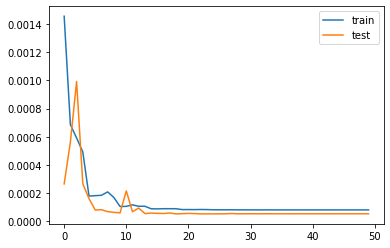

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

(7, 1) (7, 1)


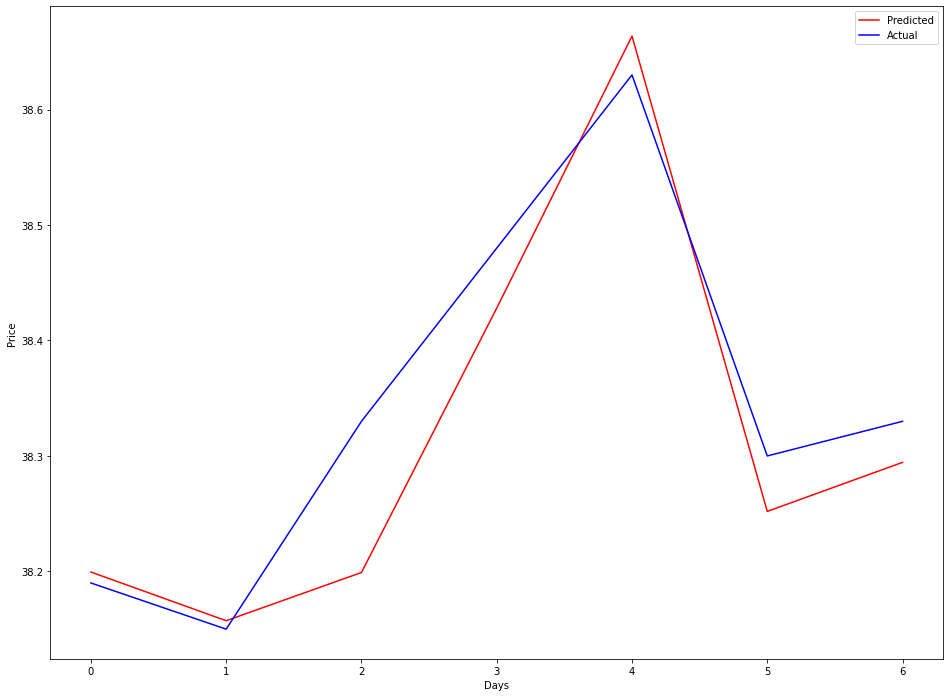

In [ ]:
# Predicting next 10 days
model_ = load_model("/content/model_ABT_open.hdf5")
_X,_y = preprocessor(data.iloc[-11:,[1,2,3,4]].values,data.iloc[-11:,0].values,4,test=True)
org,pred = predictor(model_,_X,_y)

In [ ]:
win = 0
loss = 0
for i in range(1,len(org)):
  if pred[i] > pred[i-1] and org[i] > org[i-1]:
    win += 1
  elif pred[i] < pred[i-1] and org[i] < org[i-1]:
    win += 1
  else:
    loss+=1
print(win,loss)
print("Trend prediction success probablity:",((win/(win+loss))*100))
print("Trend prediction loss probablity:",((loss/(win+loss))*100))

6 0
Trend prediction success probablity: 100.0
Trend prediction loss probablity: 0.0


##Predicting Close price



In [ ]:
X = data.iloc[:-10,[0,2,3,4]].values
y = data.iloc[:-10,1].values
pre_X,pre_y = preprocessor(X,y,4)
train_X,train_y,test_X,test_y = data_shuffler(pre_X,pre_y,0.85)
history,model,model1 = model_build(train_X,train_y,test_X,test_y,learning_rate=0.001,epochs=50,batch_size=1,name='close',comp=company)

Epoch 1/50
1475/1485 [============================>.] - ETA: 0s - loss: 0.0019 - mean_absolute_error: 0.0321
Epoch 00001: val_loss improved from inf to 0.00090, saving model to model_ABT_close.hdf5
1485/1485 [==============================] - 6s 4ms/step - loss: 0.0019 - mean_absolute_error: 0.0320 - val_loss: 8.9545e-04 - val_mean_absolute_error: 0.0230 - lr: 0.0100
Epoch 2/50
1482/1485 [============================>.] - ETA: 0s - loss: 0.0011 - mean_absolute_error: 0.0252
Epoch 00002: val_loss improved from 0.00090 to 0.00055, saving model to model_ABT_close.hdf5
1485/1485 [==============================] - 5s 4ms/step - loss: 0.0011 - mean_absolute_error: 0.0251 - val_loss: 5.4864e-04 - val_mean_absolute_error: 0.0177 - lr: 0.0100
Epoch 3/50
1471/1485 [============================>.] - ETA: 0s - loss: 8.9991e-04 - mean_absolute_error: 0.0232
Epoch 00003: val_loss did not improve from 0.00055
1485/1485 [==============================] - 5s 3ms/step - loss: 8.9303e-04 - mean_absolute_

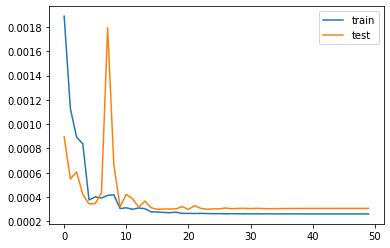

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

(7, 1) (7, 1)


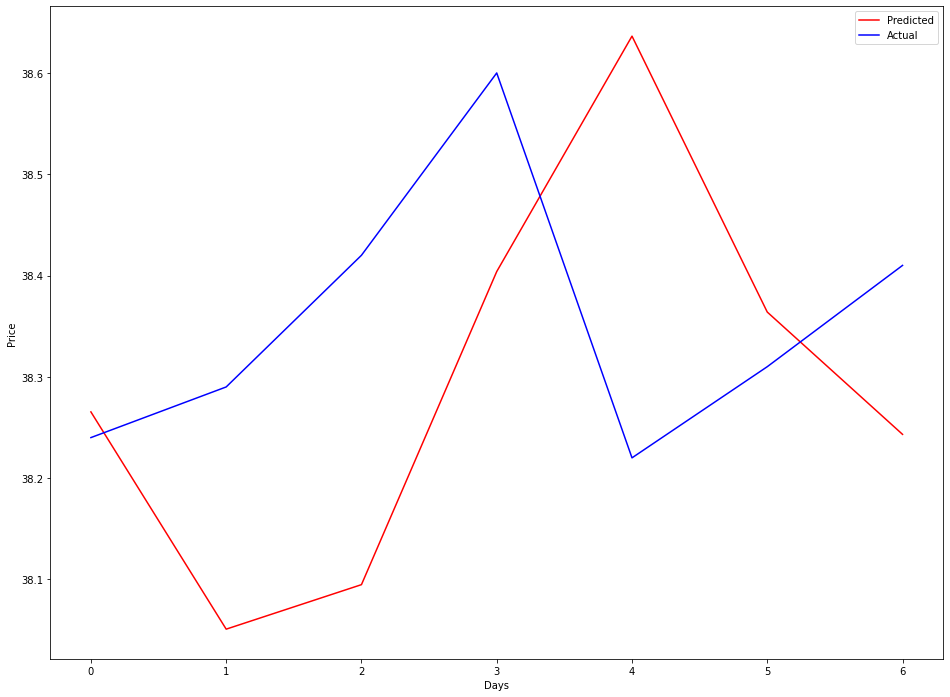

In [ ]:
# Predicting next 10 days
model_ = load_model("/content/model_ABT_close.hdf5")
_X,_y = preprocessor(data.iloc[-11:,[0,2,3,4]].values,data.iloc[-11:,1].values,4,test=True)
org,pred = predictor(model_,_X,_y)

In [ ]:
win = 0
loss = 0
for i in range(1,len(org)):
  if pred[i] > pred[i-1] and org[i] > org[i-1]:
    win += 1
  elif pred[i] < pred[i-1] and org[i] < org[i-1]:
    win += 1
  else:
    loss+=1
print(win,loss)
print("Trend prediction success probablity:",((win/(win+loss))*100))
print("Trend prediction loss probablity:",((loss/(win+loss))*100))

2 4
Trend prediction success probablity: 33.33333333333333
Trend prediction loss probablity: 66.66666666666666


The LSTM for Close and Open have same architecture that's why it has low success probability. We can find a separate optimized model for **Close Price**. Similarly for High and Low.

## Prediction High

In [ ]:
X = data.iloc[:-10,[0,1,2,4]].values
y = data.iloc[:-10,3].values
pre_X,pre_y = preprocessor(X,y,4)
train_X,train_y,test_X,test_y = data_shuffler(pre_X,pre_y,0.85)
history,model,model3 = model_build(train_X,train_y,test_X,test_y,learning_rate=0.001,epochs=50,batch_size=1,name='high',comp=company)

Epoch 1/50
1481/1485 [============================>.] - ETA: 0s - loss: 0.0032 - mean_absolute_error: 0.0367
Epoch 00001: val_loss improved from inf to 0.00190, saving model to model_ABT_high.hdf5
1485/1485 [==============================] - 6s 4ms/step - loss: 0.0032 - mean_absolute_error: 0.0367 - val_loss: 0.0019 - val_mean_absolute_error: 0.0359 - lr: 0.0100
Epoch 2/50
1481/1485 [============================>.] - ETA: 0s - loss: 8.1503e-04 - mean_absolute_error: 0.0216
Epoch 00002: val_loss improved from 0.00190 to 0.00094, saving model to model_ABT_high.hdf5
1485/1485 [==============================] - 5s 3ms/step - loss: 8.1325e-04 - mean_absolute_error: 0.0216 - val_loss: 9.4350e-04 - val_mean_absolute_error: 0.0248 - lr: 0.0100
Epoch 3/50
1479/1485 [============================>.] - ETA: 0s - loss: 4.9066e-04 - mean_absolute_error: 0.0170
Epoch 00003: val_loss did not improve from 0.00094
1485/1485 [==============================] - 5s 3ms/step - loss: 4.9754e-04 - mean_absolut

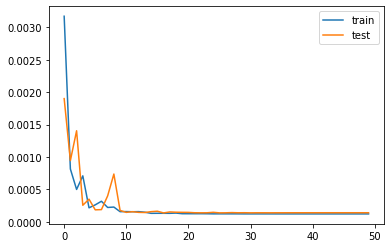

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

(7, 1) (7, 1)


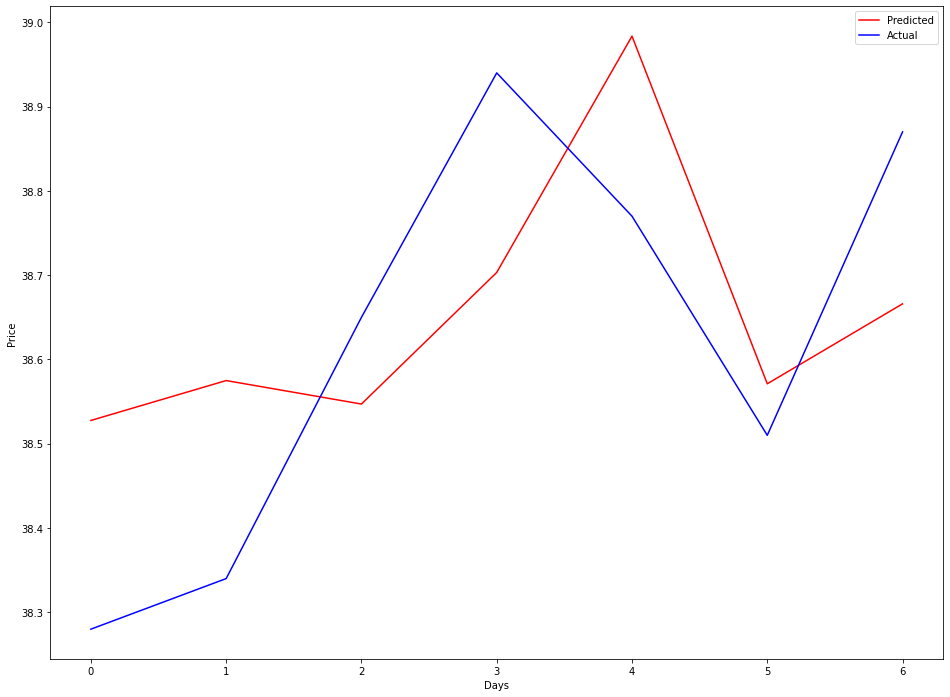

In [ ]:
model_ = load_model("/content/model_ABT_high.hdf5")
_X,_y = preprocessor(data.iloc[-11:,[0,1,2,4]].values,data.iloc[-11:,3].values,4,test=True)
org,pred = predictor(model_,_X,_y)

## Prediction Low

In [ ]:
X = data.iloc[:-10,[0,1,3,4]].values
y = data.iloc[:-10,2].values
pre_X,pre_y = preprocessor(X,y,4)
train_X,train_y,test_X,test_y = data_shuffler(pre_X,pre_y,0.85)
history,model,model4 = model_build(train_X,train_y,test_X,test_y,learning_rate=0.001,epochs=50,batch_size=1,name='low',comp=company)

Epoch 1/50
1470/1485 [============================>.] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.0344
Epoch 00001: val_loss improved from inf to 0.00042, saving model to model_ABT_low.hdf5
1485/1485 [==============================] - 6s 4ms/step - loss: 0.0024 - mean_absolute_error: 0.0342 - val_loss: 4.2026e-04 - val_mean_absolute_error: 0.0150 - lr: 0.0100
Epoch 2/50
1471/1485 [============================>.] - ETA: 0s - loss: 0.0010 - mean_absolute_error: 0.0234
Epoch 00002: val_loss did not improve from 0.00042
1485/1485 [==============================] - 5s 3ms/step - loss: 0.0010 - mean_absolute_error: 0.0233 - val_loss: 5.0811e-04 - val_mean_absolute_error: 0.0181 - lr: 0.0100
Epoch 3/50
1481/1485 [============================>.] - ETA: 0s - loss: 7.2278e-04 - mean_absolute_error: 0.0195
Epoch 00003: val_loss did not improve from 0.00042
1485/1485 [==============================] - 5s 3ms/step - loss: 7.2238e-04 - mean_absolute_error: 0.0195 - val_loss: 4.5324e-04 - val_m

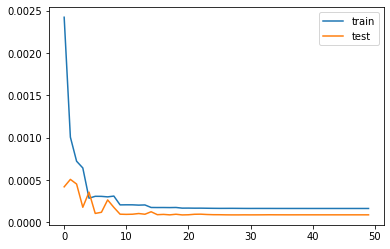

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

(7, 1) (7, 1)


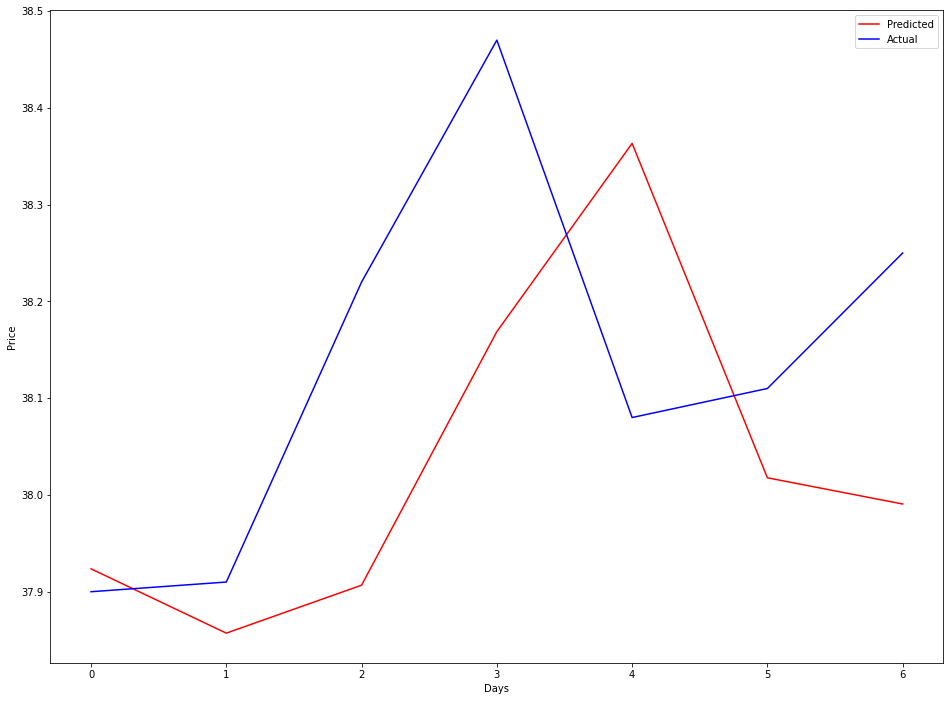

In [ ]:
model_ = load_model("/content/model_ABT_low.hdf5")
_X,_y = preprocessor(data.iloc[-11:,[0,1,3,4]].values,data.iloc[-11:,2].values,4,test=True)
org,pred = predictor(model_,_X,_y)